# Estimating engine remaining useful life

Author: Luan Glasser

E-mail: luan.glasser@gmail.com

## Information taken from C-MAPSS

>**Datasets**
>
>Data Set: FD001 |
>Train trajectories: 100 | 
>Test trajectories: 100 | 
>Conditions: ONE (Sea Level) | 
>Fault Modes: ONE (HPC Degradation)
>
>Data Set: FD002 | 
>Train trajectories: 260 | 
>Test trajectories: 259 | 
>Conditions: SIX | 
>Fault Modes: ONE (HPC Degradation) 
>
>Data Set: FD003 | 
>Train trajectories: 100 | 
>Test trajectories: 100 | 
>Conditions: ONE (Sea Level) | 
>Fault Modes: TWO (HPC Degradation, Fan Degradation) 
>
>Data Set: FD004 | 
>Train trajectories: 248 | 
>Test trajectories: 249 | 
>Conditions: SIX | 
>Fault Modes: TWO (HPC Degradation, Fan Degradation)  
>
>
>
>**Experimental Scenario**
>
>Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.
>
>The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.
>
>The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:
>
>1)	unit number
>
>2)	time, in cycles
>
>3)	operational setting 1
>
>4)	operational setting 2
>
>5)	operational setting 3
>
>6)	sensor measurement  1
>
>7)	sensor measurement  2
>
>...
>
>26)	sensor measurement  20
>
>
>
>**Reference** 
>
>A. Saxena, K. Goebel, D. Simon, and N. Eklund, “Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation”, in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.

The sensors features in the datasets correspond to the table bellow.

| Index 	|               Predictor name               	|   Unit  	|
|:-----:	|:------------------------------------------:	|:-------:	|
|   1   	| Total temperature at fan inlet             	|    Ko   	|
|   2   	| Total temperature at LPC outlet            	|    Ko   	|
|   3   	| Total temperature at HPC outlet            	|    Ko   	|
|   4   	| Total temperature at LPT outlet            	|    Ko   	|
|   5   	| Pressure at fan inlet                      	|   psia  	|
|   6   	| Total pressure in bypass-duct              	|   psia  	|
|   7   	| Total pressure HPC outlet                  	|   psia  	|
|   8   	| Physical fan speed                         	|   rpm   	|
|   9   	| Physical core speed                        	|   rpm   	|
|   10  	| Engine pressure ratio                      	|    -    	|
|   11  	| Static pressure at HPC outlet              	|   psia  	|
|   12  	| Ratio of fuel flow to “16”                 	| pps/psi 	|
|   13  	| Corrected fan speed                        	|   rpm   	|
|   14  	| Corrected core speed                       	|   rpm   	|
|   15  	| Bypass ratio  – 16 Burner fuel-air   ratio 	|    –    	|
|   17  	| Bleed Bleed enthalpy                       	|    –    	|
|   18  	| Demanded fan speed                         	|   rpm   	|
|   19  	| Demanded core fan speed                    	|   rpm   	|
|   20  	| HPT coolant bleed                          	|  lbm/s  	|
|   21  	| LPT coolant bleed                          	|  lbm/s  	|

## General libraries

In [470]:
# Import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Loading data

In [471]:
# Load the training data
df_train_fd001 = pd.read_csv('../dataset_nasa/train_FD001.txt', sep = " ", header = None).drop(columns = [26, 27])
df_train_fd002 = pd.read_csv('../dataset_nasa/train_FD002.txt', sep = " ", header = None).drop(columns = [26, 27])
df_train_fd003 = pd.read_csv('../dataset_nasa/train_FD003.txt', sep = " ", header = None).drop(columns = [26, 27])
df_train_fd004 = pd.read_csv('../dataset_nasa/train_FD004.txt', sep = " ", header = None).drop(columns = [26, 27])

# Load the test data
df_test_fd001 = pd.read_csv('../dataset_nasa/test_FD001.txt', sep = " ", header = None).drop(columns = [26, 27])
df_test_fd002 = pd.read_csv('../dataset_nasa/test_FD002.txt', sep = " ", header = None).drop(columns = [26, 27])
df_test_fd003 = pd.read_csv('../dataset_nasa/test_FD003.txt', sep = " ", header = None).drop(columns = [26, 27])
df_test_fd004 = pd.read_csv('../dataset_nasa/test_FD004.txt', sep = " ", header = None).drop(columns = [26, 27])

# Load the RUL data
df_rul_fd001 = pd.read_csv('../dataset_nasa/RUL_FD001.txt', sep = " ", header = None).drop(columns = [1])
df_rul_fd002 = pd.read_csv('../dataset_nasa/RUL_FD002.txt', sep = " ", header = None).drop(columns = [1])
df_rul_fd003 = pd.read_csv('../dataset_nasa/RUL_FD003.txt', sep = " ", header = None).drop(columns = [1])
df_rul_fd004 = pd.read_csv('../dataset_nasa/RUL_FD004.txt', sep = " ", header = None).drop(columns = [1])

## Renaming features

In [472]:
# Define names
names_list = ['unit_no', 'time_cycles', 'op_set_1', 'op_set_2', 'op_set_3', 
        'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 
        'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 
        'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 
        'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 
        'sensor_21']

# Change train features
df_train_fd001.columns = names_list
df_train_fd002.columns = names_list
df_train_fd003.columns = names_list
df_train_fd004.columns = names_list


# Change test features
df_test_fd001.columns = names_list
df_test_fd002.columns = names_list
df_test_fd003.columns = names_list
df_test_fd004.columns = names_list

# Change RUL feature
names_list = ['rul']
df_rul_fd001.columns = names_list
df_rul_fd002.columns = names_list
df_rul_fd003.columns = names_list
df_rul_fd004.columns = names_list

## Starting point

The modeling will be implemented using the _fd001 dataframes, for the sake of simplicity. It will be easy to change the dataframes after that.

In [473]:
df_train = df_train_fd001.copy()
df_test = df_test_fd001.copy()
df_rul = df_rul_fd001.copy()

## Data preparation: basic functions

First let's create the functions for generating labels for every line of the training datasets. The labels are for each line the actual operating cycles subtracted from the failure cycles.

### Assigning RUL

In [474]:
# Group by engine number
def get_max_cycles_per_unit(df):
    df = df.groupby('unit_no', as_index = False).max()[['unit_no', 'time_cycles']]
    df.columns = ['engine_no', 'max']
    return df

# Calculate the RUL for the training dataset
def calculate_rul(df, rul_df):
    df = df.merge(rul_df, how = 'left', left_on = 'unit_no', right_on = 'engine_no')
    df['rul'] = df['max'] - df['time_cycles']
    df =df.drop(columns = ['engine_no', 'max'])
    return df

def assign_rul(df):
    rul_df = get_max_cycles_per_unit(df)
    df = calculate_rul(df, rul_df)
    return df

def correct_df_test_rul(df_test, df_rul):
    df_rul.columns = ['rul_to_increment']
    df_test = df_test.merge(df_rul, how = 'left', left_on = 'unit_no', right_on = df_rul.index)
    df_test['rul'] = df_test.rul + df_test.rul_to_increment
    df_test = df_test.drop(columns = ['rul_to_increment'])
    return df_test

In [475]:
# Determine RUL
df_train = assign_rul(df_train)

# Attention! The "RUL" calculated here is not the actual RUL. We just used the assign_rul function for simplicity,
# but we are yet to increment these values with the data inside df_rul. It needs to be done because in the test set
# the engine does not run until failure, but until some cycle before failure. Hence, the df_rul provides information
# about how many cycles the engines were yet to operate.
df_test = assign_rul(df_test)

In [476]:
df_test = correct_df_test_rul(df_test, df_rul)

In [477]:
df_test.head()

,unit_no,time_cycles,op_set_1,op_set_2,op_set_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,rul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,289.0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,288.0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,287.0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,286.0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,285.0


## Train and test datasets

In [478]:
df_train.columns

Index(['unit_no', 'time_cycles', 'op_set_1', 'op_set_2', 'op_set_3',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
       'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
       'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'rul'],
      dtype='object')

In [479]:
X_train = df_train[['time_cycles',
                   'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
                   'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11',
                   'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
                   'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']].values

X_test = df_test[['time_cycles', 
                   'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
                   'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11',
                   'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
                   'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']].values

y_train = df_train['rul'].values
y_train = y_train.reshape((y_train.shape[0], 1))

y_test = df_test['rul'].values
y_test = y_test.reshape((y_test.shape[0], 1))

In [480]:
X_train.shape

(20631, 22)

In [481]:
y_train.shape

(20631, 1)

In [482]:
X_test.shape

(13096, 22)

In [483]:
y_test.shape

(13096, 1)

## Scaling the data

In [484]:
# Importing sklearn functions for normalization and scaling
from sklearn.preprocessing import normalize
from sklearn.preprocessing import robust_scale

def normalize_scale(X_train, X_test):
   
    # Normalize the values in X train and test
    X_train_norm = normalize(X_train)
    X_test_norm = normalize(X_test)
    
    # Run the normalized values through a robust scaler
    X_train_norm_robscaled = robust_scale(X_train_norm)
    X_test_norm_robscaled = robust_scale(X_test_norm) 
    
    return X_train_norm_robscaled, X_test_norm_robscaled

In [485]:
# Applying the normalization and the robust scaling. *_nrb == *_(normalized and robust scaled)
X_train_nrb, X_test_nrb = normalize_scale(X_train, X_test)

## Keras neural network model

In [486]:
# Import Keras to build and train ML model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense

# Imort sklearn fir mathmatical computation of MSE of pred-Y
from sklearn import metrics

# Import matplotlib for visualisation of results
from matplotlib import pyplot as plt

In [487]:
# Ser hyperparemeters
batch_size = 128
learning_rate = 0.011
epochs = 25

In [488]:
# Create model input format: [num_ex, num_features]
model = Sequential()

# First hidden layer
model.add(Dense(2,
                input_dim = X_train_nrb.shape[1], # Features from input X
                kernel_initializer = 'random_uniform', #Initialize W
                bias_initializer = 'zeros', #Initialize b
                activation = 'sigmoid' #Activation function
                )
         )
# Output lar
model.add(Dense(1,
                kernel_initializer = 'random_uniform',
                bias_initializer = 'zeros'
                )
         )

# Define optimizer: Only learning rate is set.
sgd = optimizers.SGD(lr = learning_rate)

# Compile model with loss function and optimizer
model.compile(loss = 'mean_squared_error', optimizer = 'sgd')

# Fit/train the model
history = model.fit(X_train_nrb, y_train, epochs = epochs, batch_size = batch_size, verbose = 0)
print('Train lowest mse: ' + str(min(history.history['loss'])))
print('Train lowest sqrt(mse): ' + str(np.sqrt(min(history.history['loss']))))

# Predict:
y_pred = model.predict(X_test_nrb)

Train lowest mse: 1612.87451171875
Train lowest sqrt(mse): 40.16060895602493


In [489]:
y_pred.shape

(13096, 1)

In [490]:
y_test.shape

(13096, 1)

In [491]:
y_pred  = [val for sublist in y_pred for val in sublist]
y_test  = [val for sublist in y_test for val in sublist]

In [492]:
# Predictions to dataframe
df_score = pd.DataFrame({'y_pred' : y_pred, 'y_test' : y_test})

In [493]:
df_score = df_score.dropna()
df_score = df_score.sort_values('y_test', ascending = False).reset_index(drop = True)

<Figure size 432x288 with 0 Axes>

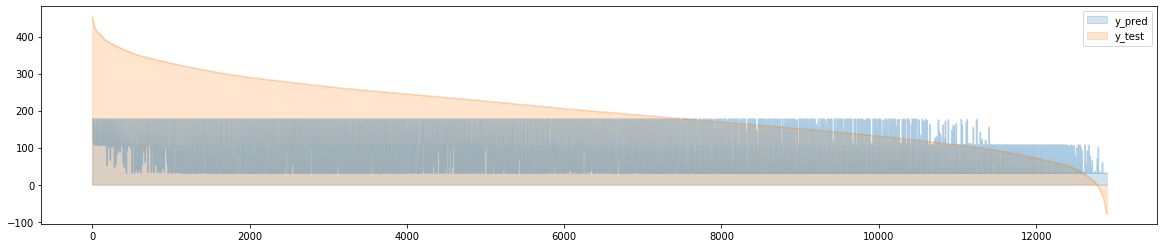

In [496]:
plt.figure()
#df_score.sample(30).sort_values('y_test', ascending = False).\
#    reset_index(drop = True).plot.area(alpha = 0.2, stacked = False, figsize = (20, 4))
df_score.sort_values('y_test', ascending = False).\
    reset_index(drop = True).plot.area(alpha = 0.2, stacked = False, figsize = (20, 4))

## Evaluating the predictions

In [495]:
from sklearn.metrics import mean_squared_error
print('Root mean squared error = {}'.format(mean_squared_error(df_score.y_test.values, df_score.y_pred.values, squared = False)))

Root mean squared error = 120.9580428442391
